#  IN3050/IN4050 Mandatory Assignment 1: Traveling Salesman Problem


## Rules
Before you begin the exercise, review the rules at this website:
https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html
(This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers
with others.)

Especially, notice that you are **not allowed to use code or parts of code written by others** in your submission. We do check your code against online repositories, so please be sure to **write all the code yourself**. Any use of **auto-generated code** must be clearly identified, along with the tool or software used to generate it. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": https://www.uio.no/english/studies/examinations/cheating/index.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, February 23 2024, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

## What to deliver?

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which includes:
* PDF report containing:
    * Your name and username (!)
    * Instructions on how to run your program, with example runs.
    * Answers to all questions from assignment.
    * Brief explanation of what you’ve done.
    * *Your PDF may be generated by exporting your Jupyter Notebook to PDF, if you have answered all questions in your notebook*
* Source code
    * Source code may be delivered as jupyter notebooks or python files (.py)
* The european cities file so the program will run right away.
* Any files needed for the group teacher to easily run your program on IFI linux machines.

**Important**: 
* Include example runs of your code by doing the reports described in the tasks. Simply implementing the code, but never running it will not give many points.
* Include the code that was used to make all reports. Do not include reports of performance and time without also including the code that was used to produce it.
* If you weren’t able to finish the assignment, use the PDF report to elaborate on what you’ve tried
and what problems you encountered. Students who have made an effort and attempted all parts of the assignment
will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

## Introduction
In this exercise, you will attempt to solve an instance of the traveling salesman problem (TSP) using different
methods. The goal is to become familiar with evolutionary algorithms and to appreciate their effectiveness on a
difficult search problem. You have to use Python to solve the assignment. You must write
your program from scratch (but you may use non-EA-related libraries).


|  &nbsp;   | Barcelona | Belgrade |  Berlin | Brussels | Bucharest | Budapest |
|:---------:|:---------:|:--------:|:-------:|:--------:|:---------:|:--------:|
| Barcelona |     0     |  1528.13 | 1497.61 |  1062.89 |  1968.42  |  1498.79 |
|  Belgrade |  1528.13  |     0    |  999.25 |  1372.59 |   447.34  |  316.41  |
|   Berlin  |  1497.61  |  999.25  |    0    |  651.62  |  1293.40  |  1293.40 |
|  Brussels |  1062.89  |  1372.59 |  651.62 |     0    |  1769.69  |  1131.52 |
| Bucharest |  1968.42  |  447.34  | 1293.40 |  1769.69 |     0     |  639.77  |
|  Budapest |  1498.79  |  316.41  | 1293.40 |  1131.52 |   639.77  |     0    |


<center>Figure 1: First 6 cities from csv file.</center>


## Problem
The traveling salesman, wishing to disturb the residents of the major cities in some region of the world in
the shortest time possible, is faced with the problem of finding the shortest tour among the cities. A tour
is a path that starts in one city, visits all of the other cities, and then returns to the starting point. The
relevant pieces of information, then, are the cities and the distances between them. In this instance of the
TSP, a number of European cities are to be visited. Their relative distances are given in the data file, *european_cities.csv*, found in the zip file with the mandatory assignment.

(You will use permutations to represent tours in your programs. The **itertools** module in Python provides
a permutations function that returns successive permutations, this is useful for exhaustive search)

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
import itertools
import statistics
import seaborn as sns
%matplotlib inline
np.random.seed(57)
#Map of Europe
europe_map = plt.imread('map.png')

#Lists of city coordinates
city_coords = {
    "Barcelona": [2.154007, 41.390205], "Belgrade": [20.46, 44.79], "Berlin": [13.40, 52.52], 
    "Brussels": [4.35, 50.85], "Bucharest": [26.10, 44.44], "Budapest": [19.04, 47.50],
    "Copenhagen": [12.57, 55.68], "Dublin": [-6.27, 53.35], "Hamburg": [9.99, 53.55], 
    "Istanbul": [28.98, 41.02], "Kyiv": [30.52, 50.45], "London": [-0.12, 51.51], 
    "Madrid": [-3.70, 40.42], "Milan": [9.19, 45.46], "Moscow": [37.62, 55.75],
    "Munich": [11.58, 48.14], "Paris": [2.35, 48.86], "Prague": [14.42, 50.07],
    "Rome": [12.50, 41.90], "Saint Petersburg": [30.31, 59.94], "Sofia": [23.32, 42.70],
    "Stockholm": [18.06, 60.33], "Vienna": [16.36, 48.21], "Warsaw": [21.02, 52.24]}


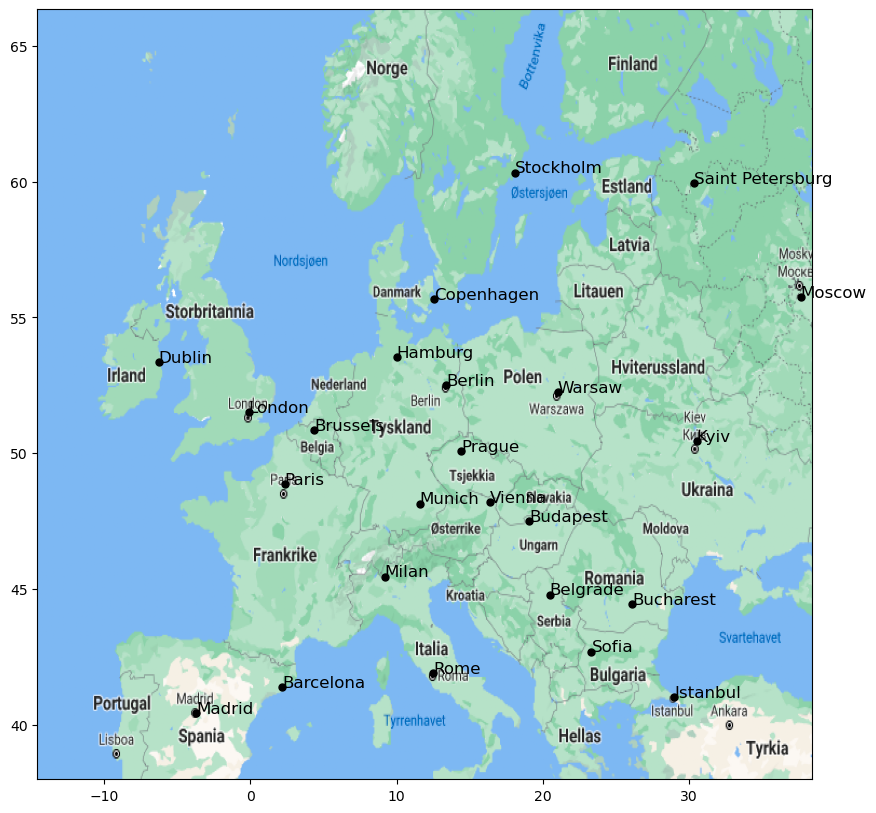

In [2]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

# Map (long, lat) to (x, y) for plotting
for city, location in city_coords.items():
    x, y = (location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12)


In [3]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) - 1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = current_city_coords[0], current_city_coords[1]
        #Plotting a line to the next city
        next_x, next_y = next_city_coords[0], next_city_coords[1]
        plt.plot([x, next_x], [y, next_y])

        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12)
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = first_city_coords[0], first_city_coords[1]
    plt.plot([next_x, first_x], [next_y, first_y])
    #Plotting a marker and index for the final city
    plt.plot(next_x, next_y, 'ok', markersize=5)
    plt.text(next_x, next_y, index+1, fontsize=12)
    plt.show()


['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul', 'Kyiv', 'London', 'Madrid', 'Milan', 'Moscow', 'Munich', 'Paris', 'Prague', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm', 'Vienna', 'Warsaw']


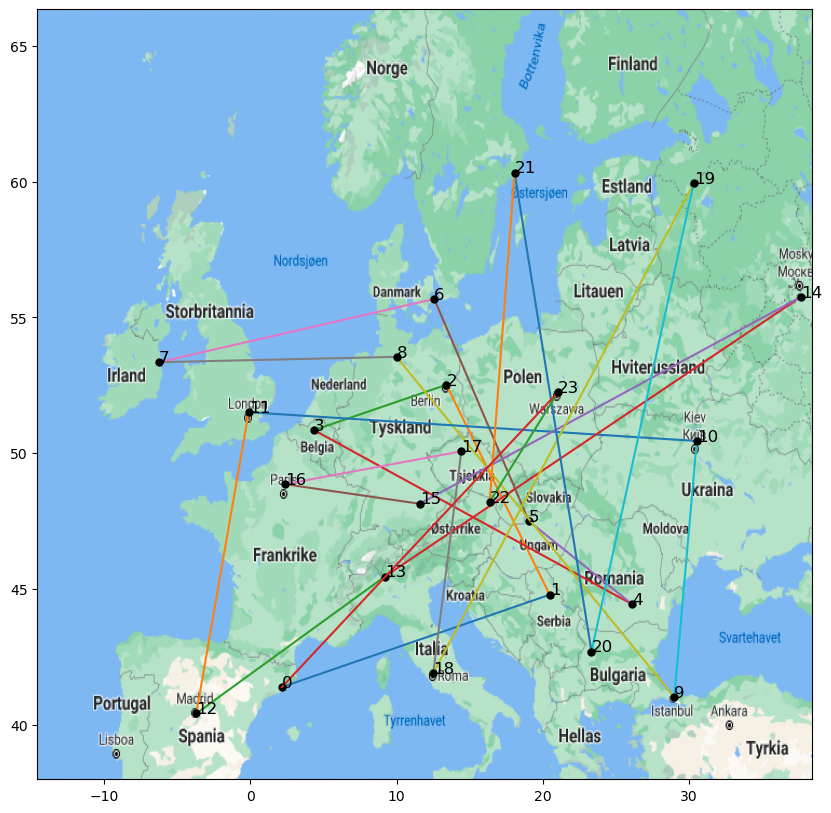

In [4]:
#Example usage of the plotting-method.
plan = list(city_coords.keys()) # Gives us the cities in alphabetic order
print(plan)
plot_plan(plan)

## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.

**Note:** To get distances between cities, use the dictionary `data` created by reading the file `european_cities.csv`. *Do not* calculate distances based on the coordinates. The actual distances do not only depend on the differences in the coordinates, but also of the curvature of the earth. The distances available in `data` are corrected for this, and contain the actual true distances.

total distance of route: 3167.3199999999997
['Bucharest', 'Belgrade', 'Budapest', 'Berlin', 'Brussels', 'Barcelona']
time used: 0.0032874960015760735


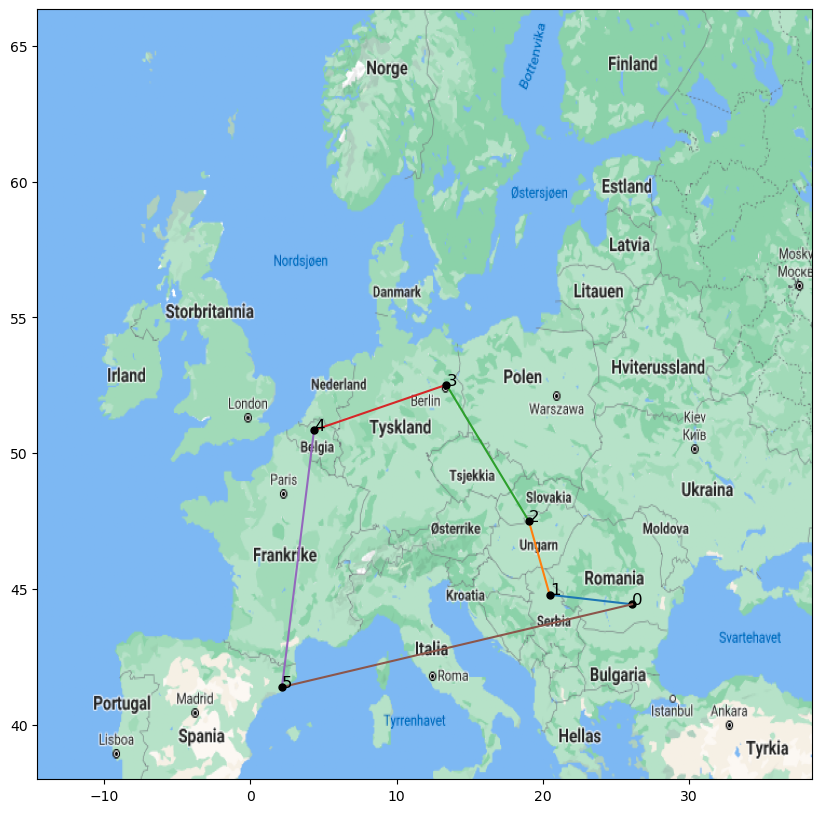

" 10 cities:\ntotal distance of rute: 5272.68\n['Barcelona', 'Dublin', 'Brussels', 'Hamburg', 'Copenhagen', 'Berlin', 'Budapest', 'Belgrade', 'Bucharest', 'Istanbul']\ntime used: 29.11982350100152\n"

In [5]:
# Implement the algorithm here
def cityMapping():
    cityMapping = {} # a map to easily find the distance from city a to city b, where the name is the key to the city index of the order in original data
    for i in range(0,len(data[0])):
        cityMapping[data[0][i]]=i+1 
    return cityMapping 
    
cityMapping = cityMapping()

def findDistance(from_cityA, to_cityB):
    startCity=cityMapping[str(from_cityA)]#for looking up in the data table easier
    currentCity = cityMapping[str(to_cityB)]-1 # -1 because of index reasons in data, [0][0] means barcelona [1][0] is barcelonas data therefore the second index needs -1 to make up for the +1 in the citymapping function
    return float(data[startCity][currentCity])


def exhaustiveSearch(nodeAmount):
    startTime = timeit.default_timer() # for calculating how long the excecution time was
    permutations = list(itertools.permutations(data[0][0:nodeAmount]))
    stack = permutations

    fittest = None
    routesMap={} #distances of all the permutations
    fittestRoutes = []
    
    while stack:
        cities = list(stack.pop())
        distance = 0
        

        #calculating distances on the route
        for i in range(1,len(cities)):
            startCity=cities[i-1]
            currentCity = cities[i] 
            distance += findDistance(startCity,currentCity)
            
        routesMap[str(cities)]=distance
       
        
        if fittest == None:
            fittest = cities
            fittestRoutes.append(cities)
            
        elif routesMap[str(fittest)] >= distance:
            fittest = cities
            fittestRoutes.append(cities)

  
    #for route in fittestRoutes:
        #print(route)
    print("total distance of route: "+ str(routesMap[str(fittest)]))
    #for i in range(1,len(fittest)):
        #print(str(findDistance(fittest[i-1],fittest[i])))
    print(fittest)
    endTime = timeit.default_timer()
    return fittest, fittestRoutes ,(endTime-startTime)
        
    
plan, altRoutes, time = exhaustiveSearch(6)
print("time used: " + str(time))
plot_plan(plan)

""" 6 cities:
total distance of rute: 3167.3199999999997
['Bucharest', 'Belgrade', 'Budapest', 'Berlin', 'Brussels', 'Barcelona']
time used: 0.004160714001045562
"""


""" 10 cities:
total distance of rute: 5272.68
['Barcelona', 'Dublin', 'Brussels', 'Hamburg', 'Copenhagen', 'Berlin', 'Budapest', 'Belgrade', 'Bucharest', 'Istanbul']
time used: 29.11982350100152
"""



What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

In [6]:
# Answer

## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 

21905.139999999996
time : 1.8058211770039634


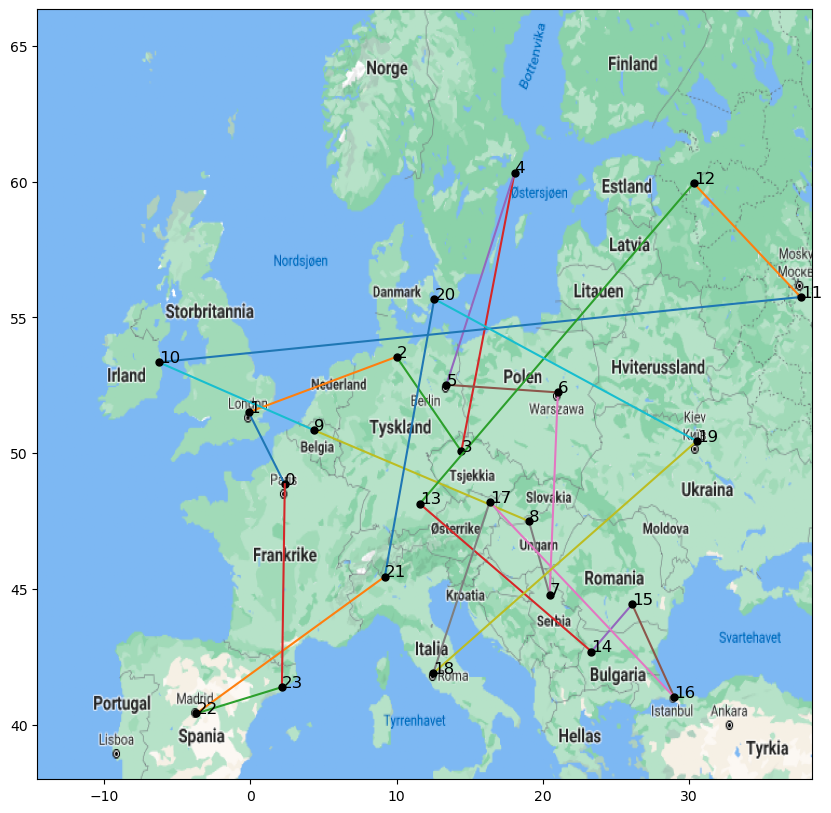

In [7]:
# Implement the algorithm here
#make random start solution and keep swat edges until no longer fruitful

#statistical funtions


def standardDeviation(population):
    distances = []
    for i in range(0,len(population)):
        distances.append(totalPathLength(population[i]))
    return statistics.stdev(distances)

def worstPath(population):
    worst = 0
    for i in range(0,len(population)):
        this = totalPathLength(population[i])
        if this> worst:
            worst = this
    return worst

def meanFitness(population):
    sumDistance = 0
    for i in range(0, len(population)):
        sumDistance += totalPathLength(population[i])
    mean = sumDistance/len(population)
    return mean


def totalPathLength(graph):
    length = 0
    for i in range(1,len(graph)):
        startCity=graph[i-1]
        currentCity = graph[i] 
        length += findDistance(startCity,currentCity)
    return length
    
def HillClimbing(cities):
    graph = np.random.permutation(data[0][0:cities])
    newGraph = list(graph)
   
   
    fails = 0
    tried = set()
    while fails<20:
     
        randomInt1 = random.randint(0, len(newGraph)-1)
        randomInt2 = random.randint(0, len(newGraph)-1)
     
        
        if str({randomInt1, randomInt2}) not in tried:
            newGraph[randomInt1], newGraph[randomInt2] = newGraph[randomInt2], newGraph[randomInt1]
            tried.add(str({randomInt1, randomInt2}))
   
            
            if totalPathLength(newGraph) < totalPathLength(graph): 
                graph = newGraph
                fails=0
                
            else:
                escapeOptima = random.randint(0,100)< (50)
                if escapeOptima:#in order to sometimes choose bad solutions to escape local optima
                    graph = newGraph
                   
                fails+=1
           
        
    return graph, totalPathLength(graph)

def bestHill(iterations, cities):
    path, length = HillClimbing(cities)
    bestPath = path
    bestLength= length
    for i in range(0,iterations):
        path, length = HillClimbing(cities)

        if bestLength>length:
            bestPath = path
            bestLength= length
    return bestPath, bestLength

startTime = timeit.default_timer() # for calculating how long the excecution time was
path, length = bestHill(2000,24)
print(length)
endTime = timeit.default_timer()
print("time : " + str(endTime-startTime))
plot_plan(path)


    

## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. This means that the x-axis should be the generations over time and the y-axis should be the average (over the 20-runs) fitness of the best gene in that generation. Conclude which is best in terms of tour length and number of generations of evolution time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.

average : 21752.35
worst : 24426.77
mean : 21752.397000000004
standard deviation : 1565.9729010161202
Overall best distance : 18691.600000000002


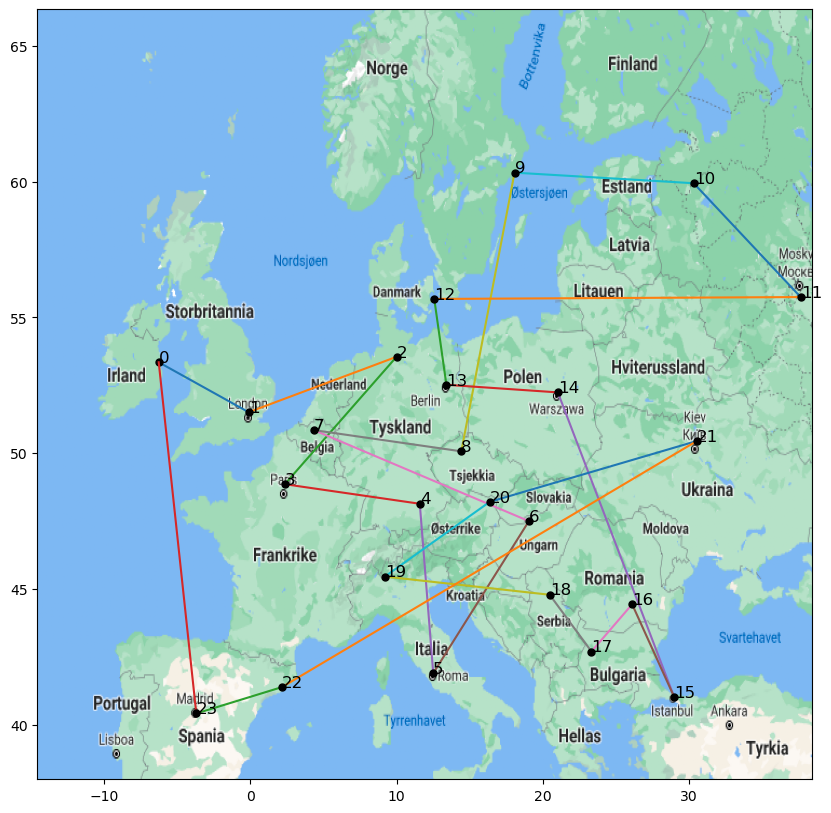

average : 20401.95
worst : 22320.74
mean : 20401.9945
standard deviation : 1201.5408183244285
Overall best distance : 18448.140000000003


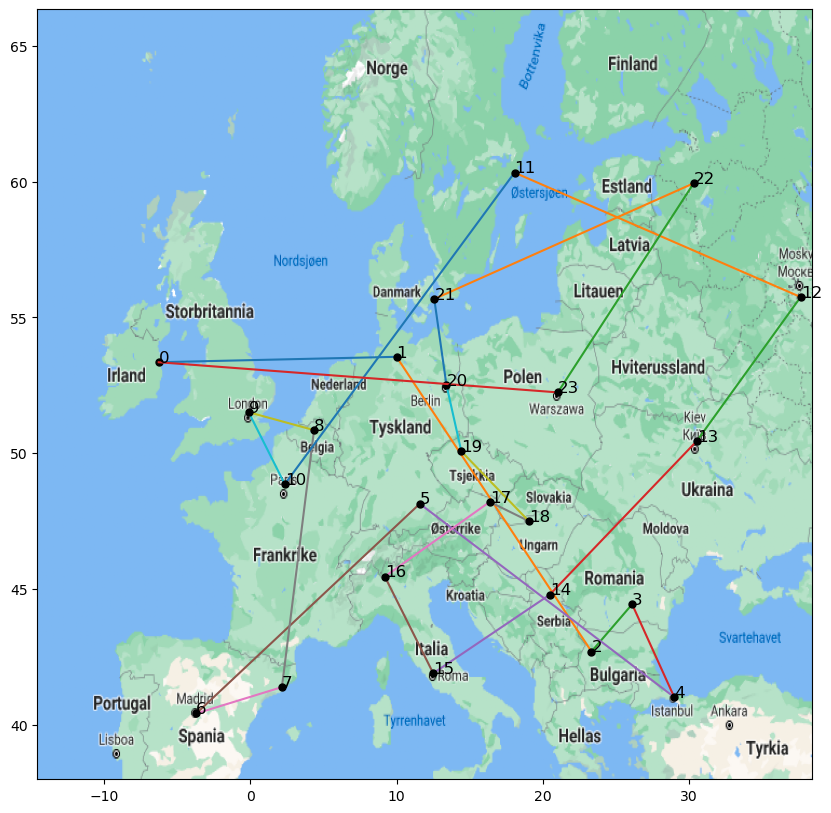

average : 19783.5
worst : 21475.83
mean : 19783.530500000004
standard deviation : 1046.4950867763819
Overall best distance : 17545.899999999998


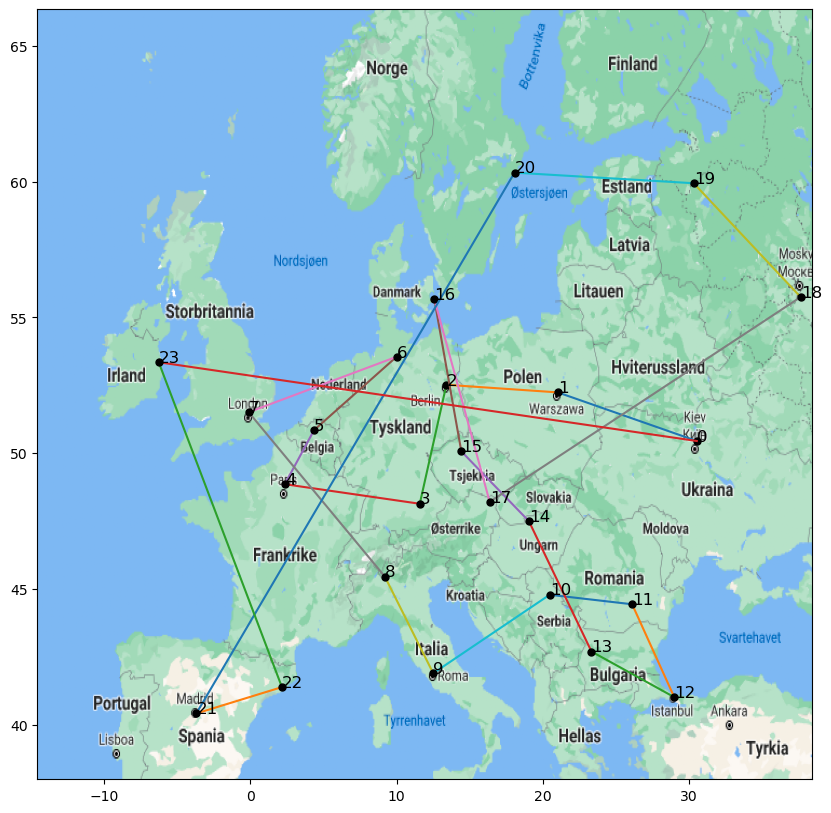

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

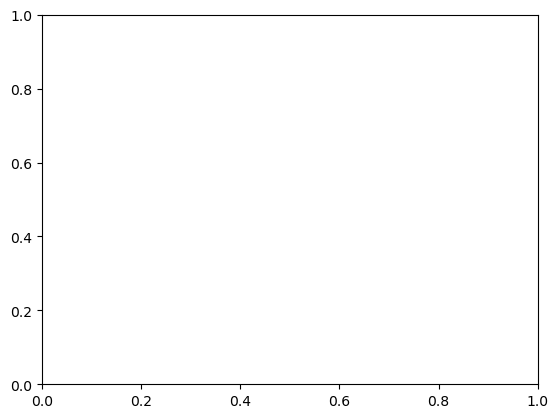

In [74]:
# Implement the algorithm here
def swapMutation(list):
    
    i = random.randint(0,len(list)-1)
    j = random.randint(0, len(list)-1)
    list[i], list[j] = list[j], list[i]
    return list
    
    
def pmx(parent1, parent2):#partiallyMappedCrossover
    
    cut1 = random.randint(0,len(parent1)-1)
    cut2 = random.randint(0,len(parent1)-1)

    child1 = np.full_like(parent1,-1)
    child2 = np.full_like(parent2,-1)

    child1[cut1:cut2+1] = parent2[cut1:cut2+1]
    child2[cut1:cut2+1] = parent1[cut1:cut2+1]

    map1 = {}
    map2 = {}

#filling the maps
    for i in range(cut1, cut2+1):
        map1[parent1[i]] = parent2[i]
        map2[parent2[i]] = parent1[i]

    #filling the children
    for i in range(0,len(child1)):
        if i <cut1 or i >cut2:
            #filling child1
            if parent1[i] not in map2:
                child1[i] = parent1[i]
            else:
                element = parent1[i]
                while element in map2:
                    element = map2[element]
                child1[i] = element

            #filling child2
            if parent2[i] not in map1:
                    child2[i] = parent2[i]
            else:
                element = parent2[i]
                while element in map1:
                    element = map1[element]
                child2[i] = element
            
    return list(child1) , list(child2)

   #find fittest
def findFittest(population):
    fittest = None
    for i in range(0,len(population)):
        if fittest == None:
            fittest = population[i]
            
        elif fitnessRanking(fittest)< fitnessRanking(population[i]):
            fittest = population[i]
    
    return fittest

    
    
def fitnessRanking(path):
    epsilon = 1e-6
    return 1/(totalPathLength(path) + epsilon)


def totalFitnessSum(population):
    sum = 0
    for i in range(0,len(population)):
        sum+=fitnessRanking(population[i])
        
    return sum
    
def GA(cities, populationSize, generations):
    population = [] #initial population is randomized

    for i in range(0,int(populationSize)):
        population.append(list(np.random.permutation(data[0][0:cities])))

    def makeOffspring(parent1,parent2):
        offspring1, offspring2 = pmx(parent1,parent2)

        mutationChance1 = random.randint(0,100)
        mutationChance2 = random.randint(0,100)
        if mutationChance1 < 10:
            swapMutation(offspring1)
        if mutationChance2 < 10:
            swapMutation(offspring2)

        return list(offspring1), list(offspring2)
    
    def survivingPopulation(population): # for finding future parents
        totalPopulationSum = 0
        survivers = []
        #keeping the fittest from every generation
        survivers.append(findFittest(population))
        totalFitnesSum= totalFitnessSum(population)

        for i in range(0,len(population)):
            
            probability = fitnessRanking(population[i])/(totalFitnesSum)
            if probability > random.randint(0, int(totalFitnesSum)):
                survivers.append(population[i])
            if len(survivers)>=populationSize:
                return survivers
                    
        return survivers

    
    #statistical datastructures
    bestOfGenerationX = [] #for showing statistical data in the end
    generationNumberX = [] # just the generation numbers 1,2,3,4,5
    meanGenerationX =[]
    standardDeviationGenX = []
    worstGenX = []
    
    for i in range(1,generations+1):
        
        bestOfGenerationX.append(totalPathLength(findFittest(population))) #for statistical graph
        generationNumberX.append( i) # for statistics
        standardDeviationGenX.append(standardDeviation(population))
        meanGenerationX.append(meanFitness(population))
        worstGenX.append(worstPath(population))
                                  
        survivers = survivingPopulation(population)
 
        population = []#resetting population and filling up with new generation
        
        for i in range(0,int(len(survivers)),2):
            offspring1, offspring2 =makeOffspring(survivers[i], survivers[i+1])
            population.append(offspring1)
            population.append(offspring2)

    fittest= findFittest(population)
    #print(fittest)
    #print(totalPathLength(fittest))
    #plt.plot( generationNumberX,bestOfGenerationX,)
    #plt.show()
    return fittest, generationNumberX, bestOfGenerationX, meanGenerationX, worstGenX, list(standardDeviationGenX)
    

#  ----------------end of actual GA algorithm, Below is statistical representations functions -----------------



# for testing, this runs the GA once with detailed statistics
def runGAandPlotGraph(cities, population, generations):
    # 8 population and 5000 generations seems good
    fittestPath, generationNumberX, bestOfGenerationX , meanGenerationX, worstGenX, standardDeviationGenX = GA(cities, population, generations)
    print(totalPathLength(fittestPath))
    print(fittestPath)
    plot_plan(fittestPath)
    plt.plot( generationNumberX,bestOfGenerationX, label="best path")
    plt.plot( generationNumberX,worstGenX, label = "worst path")
    plt.plot( list(generationNumberX),list(standardDeviationGenX), label="standard deviation")
    plt.plot( generationNumberX,meanGenerationX, label="mean" )
    plt.legend()
    plt.show()


def statisticsAndGA(cities, population, generations, iterations):
    bestPaths = []
    bestDistances = []
    meanGenerationX = []
    generationNumberX=[]

    for i in range(0,iterations):
        fittestPath, generationNumberX, bestOfGenerationX , meanGenerationX, worstGenX, standardDeviationGenX = GA(cities, population, generations)
        bestPaths.append(fittestPath)
        bestDistances.append(totalPathLength(fittestPath))
  
    
    average = int(sum(bestDistances))/int(len(bestDistances))
    bestOfAll = findFittest(bestPaths)
    worst = worstPath(bestPaths)
    mean = meanFitness(bestPaths)
    std = standardDeviation(bestPaths)

    print("average : " + str(average))
    print("worst : " + str(worst))
    print("mean : " + str(mean))
    print("standard deviation : " + str(std))
    print("Overall best distance : " + str(totalPathLength(bestOfAll)))
    plot_plan(bestOfAll)

    return bestOfGenerationX, generationNumberX

runs = []
for i in range(0, iterations):
    runs.append(i)
generations = 50
#6 cities
bestOf1, generationNumberX = statisticsAndGA(24,8,generations,20)
#10 cities
bestOf2, generationNumberX = statisticsAndGA(24,20,generations,20)
#24 citiess
bestOf3, generationNumberX = statisticsAndGA(24,50,generations,20)

plt.plot(generationNumberX, bestOf1, label="population size 8")
plt.plot(generationNumberX, bestOf2, label="population size 20")
plt.plot(generationNumberX, bestOf3, label="population size 50")
plt.legend()
plt.show()


12732.61
['Istanbul', 'Sofia', 'Belgrade', 'Budapest', 'Vienna', 'Milan', 'Munich', 'Prague', 'Warsaw', 'Berlin', 'Copenhagen', 'Hamburg', 'Brussels', 'London', 'Dublin', 'Paris', 'Madrid', 'Barcelona', 'Rome', 'Bucharest', 'Kyiv', 'Moscow', 'Saint Petersburg', 'Stockholm']


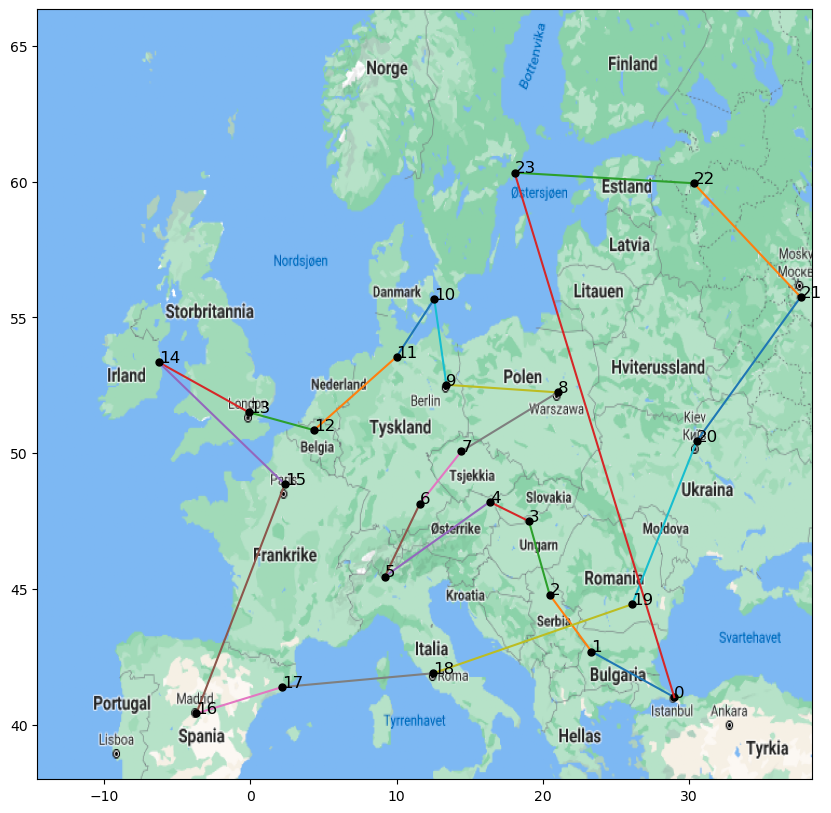

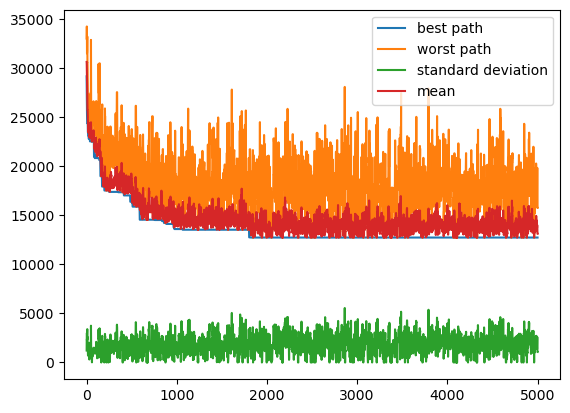

'\n\n'

In [66]:
# Answer
"""
# Report:
Altough the best performance above was the GA with populationsize 50, it took a loong time. I used 500 generations for demonstrational purposes , 
but the best overall result i got within a reasonable fast time was with a populationsize of 8 over 5000 generations. this gave me a better and 
faster result than what i got from the GA with population 50 over 500 generations. 
"""
runGAandPlotGraph(24,8,5000)
"""

"""


## Hybrid Algorithm (IN4050 only)
### Lamarckian
Lamarck, 1809: Traits acquired in parents’ lifetimes can be inherited by offspring. In general the algorithms are referred to as Lamarckian if the result of the local search stage replaces the individual in the population.
### Baldwinian
Baldwin effect suggests a mechanism whereby evolutionary progress can be guided towards favourable adaptation without the changes in individual's fitness arising from learning or development being reflected in changed genetic characteristics. In general the algorithms are referred to as Baldwinian if the original member is kept, but has as its fitness the value belonging to the outcome of the local search process.


(See chapter 10 and 10.2.1 from Eiben and Smith textbook for more details. It will also be lectured in Lecure 4)

### Task
Implement a hybrid algorithm to solve the TSP: Couple your GA and hill climber by running the hill climber a number of iterations on each individual in the population as part of the evaluation. Test both Lamarckian and Baldwinian learning models and report the results of both variants in the same way as with the pure GA (min,
max, mean and standard deviation of the end result and an averaged generational plot). How do the results compare to that of the pure GA, considering the number of evaluations done?

In [ ]:
# Implement algorithm here